In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import array_contains, col, lit, count, explode
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
import spacy

import folium
import json
import ipywidgets as widgets
from IPython.display import display

import seaborn as sns
import matplotlib.patches as mpatches
import gzip

# Academic Research: Exploring Fairness in Wikipedia Article Search 

<img src="Picture1.png" alt="fair-ranking-goal" width="1000"/>

Wikipedia article search system is used by Wikipedia coordinators who search relevant articles and looking for editing work to do. Since the search engine result pages (SERP) significantly impact the attentions recieved by different articles, we aim to develop a system that:
1. Provide **relevant** documents for users
2. Provide **fair** exposure to documents from different groups.

   
The **corpus** of the task contains more than 6 million English Wikipedia articles.

In [2]:
# example of a document in the corpus
file = '/usa/fmchen/trec_2022/trec_corpus_20220301_plain.json.gz'

with gzip.open(file, 'rb') as f:
    line = f.readline()
one_line = json.loads(line)
print(json.dumps(one_line, indent=2))

{
  "id": 12148915,
  "title": "Keith Osik",
  "url": "https://en.wikipedia.org/wiki/Keith_Osik",
  "plain": "Keith Richard Osik (born October 22, 1968), is a former Major League Baseball catcher who played in the major leagues from -. He played for the Milwaukee Brewers, Pittsburgh Pirates, Baltimore Orioles, and Washington Nationals. He was drafted in the 24th round of the  MLB Draft. His brother was also a professional baseball player, but only played in the minors. He was born in Port Washington, New York, but now lives in Shoreham, New York.\n\nOsik is currently the head baseball coach at Farmingdale State College, a Division III institution located on Long Island in New York. He was inducted into the Suffolk Sports Hall of Fame on Long Island in the Baseball Category with the Class of 2008.\n\nExternal links\n\n1968 births\nLiving people\nMajor League Baseball catchers\nBaseball players from New York (state)\nPeople from Port Washington, New York\nMilwaukee Brewers players\nPitts

In [3]:
# setup spark session to process page meta data
spark = SparkSession.builder.appName("ReadingParquet").config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.sql.autoBroadcastJoinThreshold", "-1") \
    .config("spark.executor.extraJavaOptions", "-XX:+UseG1GC -XX:G1HeapRegionSize=16m -XX:InitiatingHeapOccupancyPercent=35") \
    .getOrCreate()

meta_df = spark.read.parquet("/usa/fmchen/trec_2022/trec_2022_articles_discrete.parquet")
eval_df = spark.read.json('/usa/fmchen/trec_2022/trec_2022_eval_reldocs.jsonl')

24/05/07 22:15:43 WARN Utils: Your hostname, infochain.ece.udel.edu resolves to a loopback address: 127.0.1.1; using 128.4.30.138 instead (on interface enp25s0f0)
24/05/07 22:15:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/07 22:15:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/07 22:15:50 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [4]:
# meta_df.printSchema()

We were provided with page meta data which contains the group membership annotation. For demonstration purpose, we select **Geographic Location** (The geographic location associated with the article topic) as the example for fairness analysis.

In [5]:
# Replace empty lists with "Unknown" in meta_df
meta_df = meta_df.withColumn(
    'page_subcont_regions', 
    F.when(F.size(F.col('page_subcont_regions')) == 0, F.array(F.lit("Unknown")))
     .otherwise(F.col('page_subcont_regions'))
)
# Explode the 'page_subcont_regions' array into individual records
meta_df = meta_df.withColumn("page_subcont_region", F.explode("page_subcont_regions"))

meta_df.select(['page_id','page_subcont_region']).take(20)

[Row(page_id=12, page_subcont_region='Unknown'),
 Row(page_id=25, page_subcont_region='Unknown'),
 Row(page_id=39, page_subcont_region='Unknown'),
 Row(page_id=290, page_subcont_region='Unknown'),
 Row(page_id=303, page_subcont_region='Northern America'),
 Row(page_id=305, page_subcont_region='Unknown'),
 Row(page_id=307, page_subcont_region='Northern America'),
 Row(page_id=308, page_subcont_region='Unknown'),
 Row(page_id=309, page_subcont_region='Unknown'),
 Row(page_id=316, page_subcont_region='Northern America'),
 Row(page_id=324, page_subcont_region='Northern America'),
 Row(page_id=330, page_subcont_region='Southern Europe'),
 Row(page_id=332, page_subcont_region='Australia and New Zealand'),
 Row(page_id=334, page_subcont_region='Unknown'),
 Row(page_id=336, page_subcont_region='Unknown'),
 Row(page_id=339, page_subcont_region='Northern America'),
 Row(page_id=340, page_subcont_region='Western Europe'),
 Row(page_id=344, page_subcont_region='Northern America'),
 Row(page_id=358

**50 evaluation queries along with their relevant documents are also provided.**

Generally, relevant documents are not provided for a new search.

In [6]:
eval_df.show()

+----+--------------------+--------------------+
|  id|            rel_docs|               title|
+----+--------------------+--------------------+
| 187|[682, 954, 1170, ...|        Architecture|
| 270|[5729, 8490, 9623...|           Athletics|
| 359|[1135, 1136, 1293...|            Baseball|
| 365|[3921, 4871, 1087...|          Basketball|
| 400|[339, 628, 888, 9...|Biography/arts an...|
| 404|[595, 890, 1020, ...|Biography/sports ...|
| 480|[4191, 6811, 2472...|            COVID-19|
| 517|[1235, 5981, 1223...|Canada/WikiProjec...|
| 568|[1252, 1301, 1370...|         Catholicism|
| 596|[639, 656, 657, 9...|           Chemistry|
| 715|[659, 848, 856, 1...|           Companies|
| 807|[1425, 1428, 4527...|Dance/WikiProject...|
| 834|[25, 653, 876, 13...|          Disability|
| 881|[2699, 3975, 7661...|Elections and Ref...|
| 883|[880, 3728, 3744,...|    Electronic music|
| 949|[765, 2126, 2834,...|            Feminism|
| 951|[6237, 7770, 9325...|           Festivals|
| 955|[316, 324, 330

## Exploratory data analysis

The first step is to explore the datasets and we start with the meta datasets and examine the geographic location annotations.

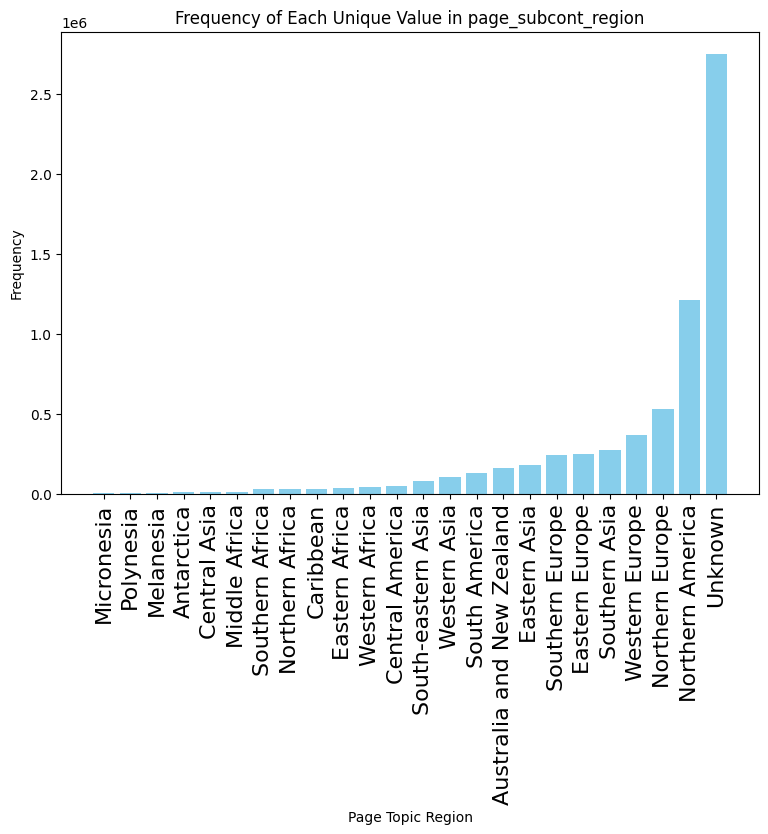

In [19]:
# Count occurrences of each unique value
frequency_df = meta_df.groupBy('page_subcont_region').count()
frequency_df = frequency_df.toPandas().sort_values(by='count')

# Plotting
plt.figure(figsize=(9, 6))
plt.bar(frequency_df['page_subcont_region'], frequency_df['count'], color='skyblue')
plt.xlabel('Page Topic Region')
plt.ylabel('Frequency')
plt.title('Frequency of Each Unique Value in page_subcont_region')
plt.xticks(rotation=90, fontsize=16)
plt.show()

* "Unknown" indicating missing data or not applicable, takes the largest portion of group membership annotations.
* Annotations are sparse and skewed.

### Group membership information of relevant documents (Geographic Location)

Let's look deeper into geographic location annotations of relevant documents of different queries.

In [8]:
# Explode rel_docs in eval_df
eval_df_exploded = eval_df.withColumn("page_id", F.explode("rel_docs"))

# Join the exploded eval_df with meta_df
joined_df = eval_df_exploded.join(meta_df, "page_id")

# Group by title and page_subcont_region, and count each group
region_counts = joined_df.groupBy("title", "page_subcont_region").count()

# Calculate the total counts per title for percentage calculation
total_counts = region_counts.groupBy("title").sum("count").withColumnRenamed("sum(count)", "total")

# Calculate percentages
final_df = region_counts.join(total_counts, "title")
final_df = final_df.withColumn("percentage", (F.col("count") / F.col("total")) * 100)

# Pivot the DataFrame to get one row per title with a column for each subcontinent region
pivot_df = final_df.groupBy("title").pivot("page_subcont_region").sum("percentage")

# Collect the data for plotting
plot_data_geo = pivot_df.toPandas().set_index("title")

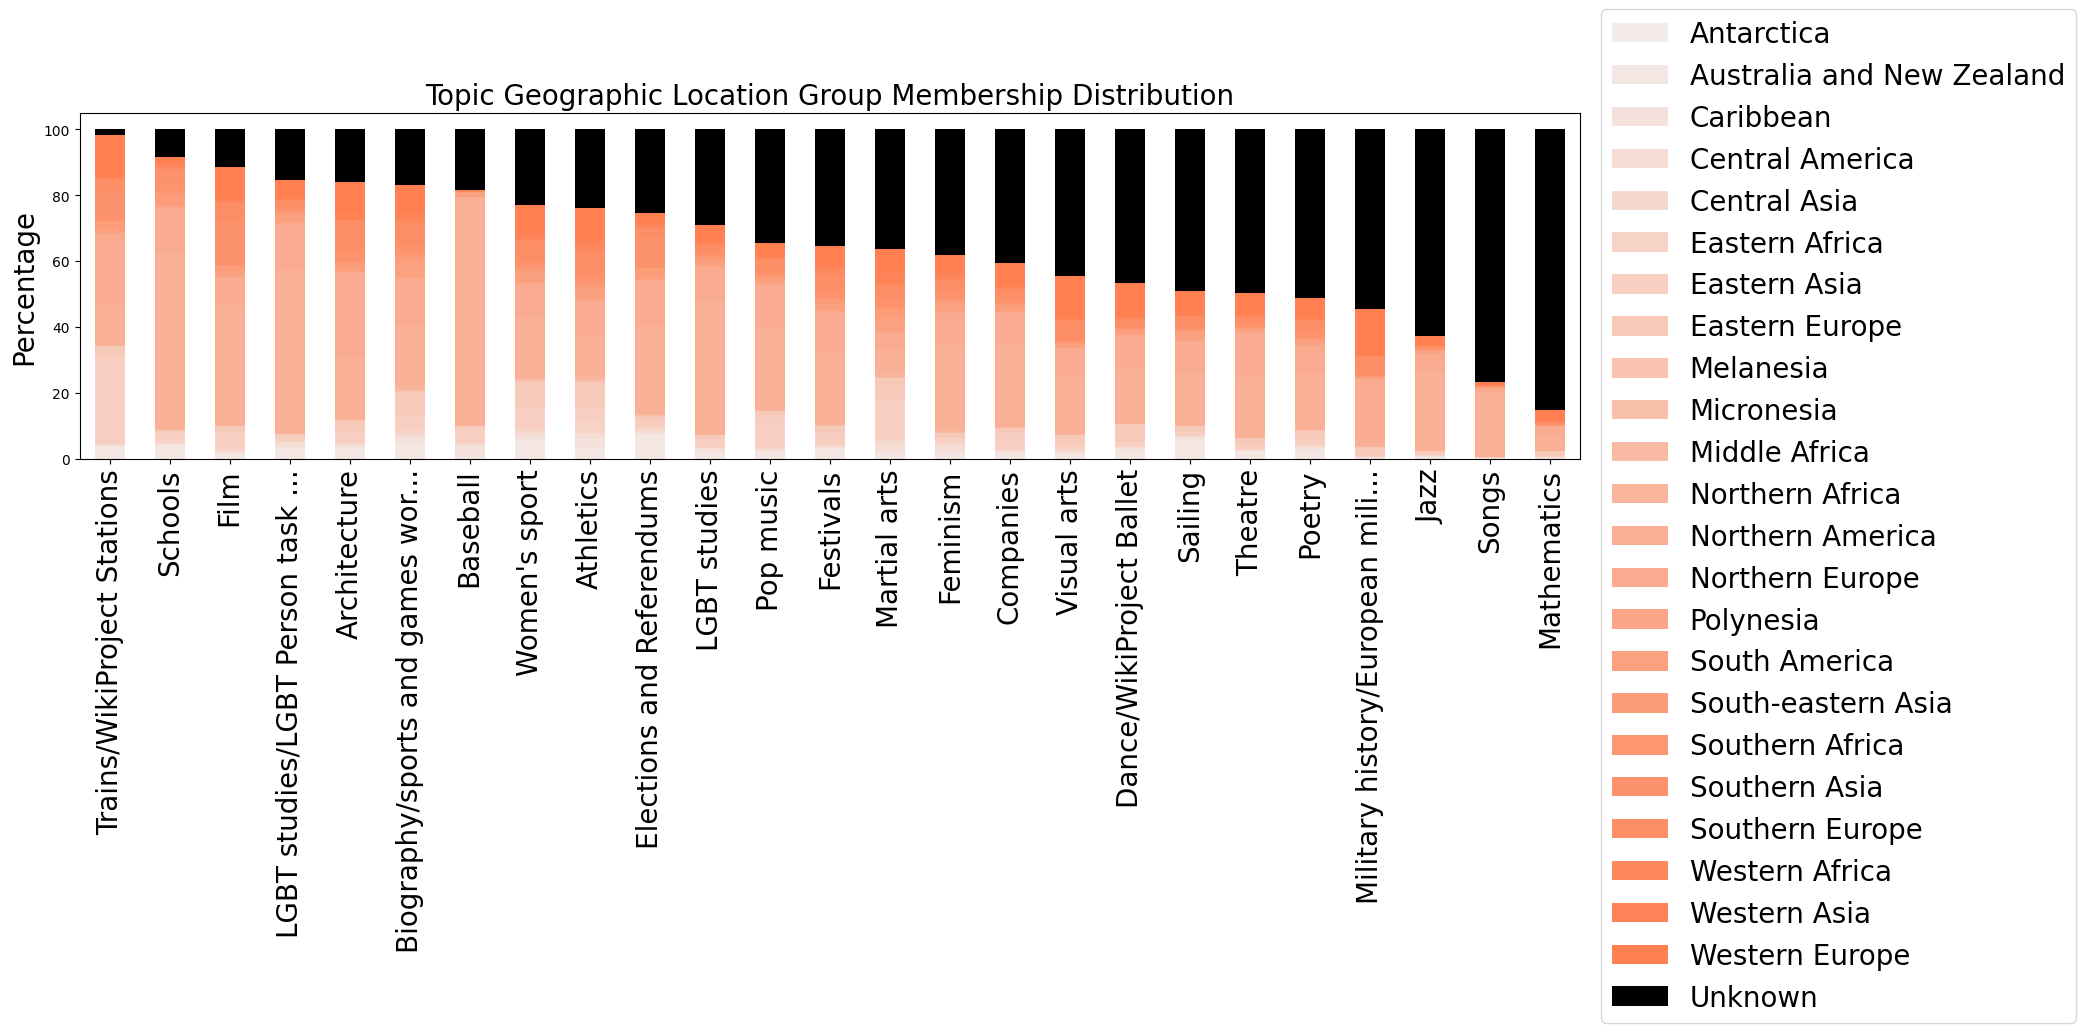

In [23]:
# Ensure 'Unknown' is the last column
plot_data_geo = plot_data_geo[[col for col in plot_data_geo.columns if col != 'Unknown'] + ['Unknown']]
plot_data_geo = plot_data_geo.sort_values(by='Unknown')
# Define the number of light colors needed (excluding 'Unknown')
n_colors_geo = len(plot_data_geo.columns) - 1

base_color = sns.color_palette(["coral"])[0]
light_palette_geo = sns.light_palette(base_color, n_colors_geo + 1)[1:]
light_palette_geo.append('black')  # Ensure 'Unknown' is black

fig, ax = plt.subplots(figsize=(16, 9))

# Plot the geographic location distribution
plot_data_geo[::2].plot(kind='bar', stacked=True, ax=ax, color=light_palette_geo)
ax.set_title('Topic Geographic Location Group Membership Distribution', fontsize=20)
ax.set_ylabel('Percentage', fontsize=20)
ax.set_xlabel('')
ax.set_xticklabels([label[:30] + '...' if len(label) > 30 else label for label in plot_data_geo[::2].index], rotation=90, fontsize=20)
plt.tight_layout()

# Create custom patches for the legend
known_patch = mpatches.Patch(color=light_palette_geo[-2], label='Known Groups')
unknown_patch = mpatches.Patch(color='black', label='Unknown Group')

# Add the legend to the plot
ax.legend(bbox_to_anchor=(1.34, 1.34), loc='upper right', fontsize=20) # handles=[known_patch, unknown_patch]

# Show the plot
plt.show()

To see the difference between queries with high portion of "Unknown" V.S. low portion of "Unknown", we define two groups:

In [10]:
# group 1
plot_data_geo[plot_data_geo['Unknown']>=50].index

Index(['Poetry', 'Military history/World War II task force',
       'Military history/European military history task force',
       'Electronic music', 'Jazz', 'Linguistics', 'Songs', 'Chemistry',
       'Mathematics', 'Fishes'],
      dtype='object', name='title')

In [11]:
# group 2
plot_data_geo[plot_data_geo['Unknown']<=30].index

Index(['Trains/WikiProject Stations', 'Rivers', 'Schools',
       'Canada/WikiProject Political parties and politicians in Canada',
       'Film', 'Higher education', 'LGBT studies/LGBT Person task force',
       'Ice Hockey', 'Architecture', 'Football',
       'Biography/sports and games work group', 'Olympics', 'Baseball',
       'Basketball', 'Women's sport', 'Women writers', 'Athletics',
       'Biography/arts and entertainment work group',
       'Elections and Referendums', 'Journalism', 'LGBT studies'],
      dtype='object', name='title')

Then we use pre-trained models to see the contextual relationship between these topics and "geographic location".

/nvme/fmchen/anaconda3/envs/wptrec/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/nvme/fmchen/anaconda3/envs/wptrec/lib/python3.8/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


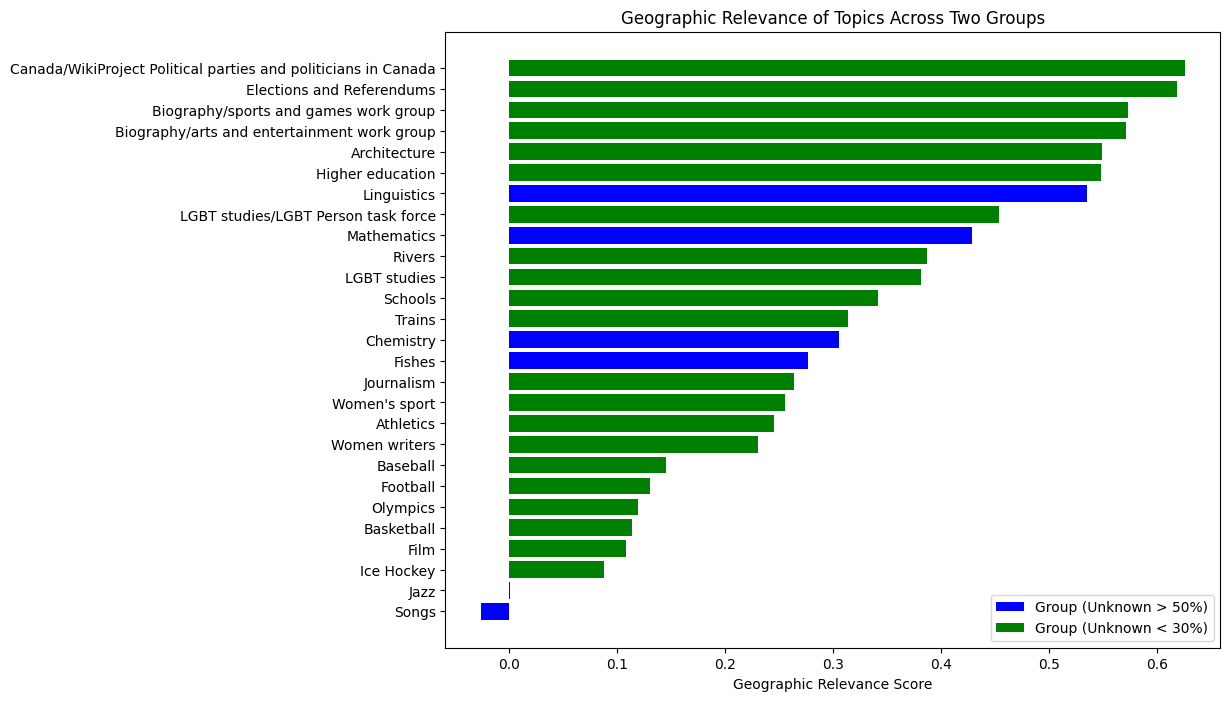

In [12]:
# Load spaCy model
nlp = spacy.load('en_core_web_lg')

# Define topics in both groups
group1 = ['Jazz', 'Linguistics', 'Songs', 'Chemistry', 'Mathematics', 'Fishes']
group2 = ['Trains', 'Rivers', 'Schools', 'Canada/WikiProject Political parties and politicians in Canada',
          'Film', 'Higher education', 'LGBT studies/LGBT Person task force', 'Ice Hockey', 'Architecture',
          'Football', 'Biography/sports and games work group', 'Olympics', 'Baseball', 'Basketball',
          'Women\'s sport', 'Women writers', 'Athletics', 'Biography/arts and entertainment work group',
          'Elections and Referendums', 'Journalism', 'LGBT studies']

# Geographic keywords
geo_keywords = ['geographic location']
geo_tokens = [nlp(keyword) for keyword in geo_keywords]

# Function to calculate geographic relevance scores
def calculate_scores(topics):
    scores = {}
    for topic in topics:
        topic_token = nlp(topic)
        similarities = [topic_token.similarity(geo_token) for geo_token in geo_tokens]
        scores[topic] = sum(similarities) / len(similarities)
    return scores

# Calculate scores for each group
group1_scores = calculate_scores(group1)
group2_scores = calculate_scores(group2)

# Merging the scores into a single dictionary for plotting
all_scores = {**{topic: score for topic, score in group1_scores.items()},
              **{topic: score for topic, score in group2_scores.items()}}

# Sorting topics for plotting (merge both groups)
all_topics_sorted = {k: v for k, v in sorted(all_scores.items(), key=lambda item: item[1], reverse=True)}

# Creating color mapping based on group membership
colors = ['blue' if topic in group1 else 'green' for topic in all_topics_sorted.keys()]

# Plotting
plt.figure(figsize=(10, 8))
bars = plt.barh(list(all_topics_sorted.keys()), list(all_topics_sorted.values()), color=colors)
plt.xlabel('Geographic Relevance Score')
plt.title('Geographic Relevance of Topics Across Two Groups')
plt.gca().invert_yaxis()  # Higher scores at the top

# Adding a legend
blue_patch = plt.Rectangle((0,0),1,1,fc="blue", edgecolor = 'none', label='Group (Unknown > 50%)')
green_patch = plt.Rectangle((0,0),1,1,fc='green', edgecolor = 'none', label='Group (Unknown < 30%)')
plt.legend(handles=[blue_patch, green_patch], loc='best')

plt.show()

### Geographic location subgroup by continent

To reduce the complexity, we merge regions into continents.

In [13]:
region_mapping = {
    'Antarctica': 'Antarctica',
    'Australia and New Zealand': 'Oceania',
    'Caribbean': 'North America',
    'Central America': 'North America',
    'Central Asia': 'Asia',
    'Eastern Africa': 'Africa',
    'Eastern Asia': 'Asia',
    'Eastern Europe': 'Europe',
    'Melanesia': 'Oceania',
    'Micronesia': 'Oceania',
    'Middle Africa': 'Africa',
    'Northern Africa': 'Africa',
    'Northern America': 'North America',
    'Northern Europe': 'Europe',
    'Polynesia': 'Oceania',
    'South America': 'South America',
    'South-eastern Asia': 'Asia',
    'Southern Africa': 'Africa',
    'Southern Asia': 'Asia',
    'Southern Europe': 'Europe',
    'Unknown': 'Other',
    'Western Africa': 'Africa',
    'Western Asia': 'Asia',
    'Western Europe': 'Europe'
}

# prepare df for mapping
df = plot_data_geo.T
df['Subregion'] = df.index.map(region_mapping)
result_df = df.groupby('Subregion').sum()
result_df = result_df.T

In [17]:
# Load GeoJSON data
with open('world_geo_low.json', 'r') as f:
    geo_json_data = json.load(f)

# Function to create a Choropleth map for a given topic
def create_map(topic):
    # Prepare DataFrame for mapping
    df = result_df.loc[topic].reset_index()
    df.columns = ['Continent', 'Percentage']  # Make sure these match your DataFrame structure
    
    # Merge the DataFrame with the GeoJSON properties
    for feature in geo_json_data['features']:
        continent = feature['properties']['continent']
        # Match the continent and attach the percentage value for the tooltip
        if continent in df['Continent'].values:
            feature['properties']['Percentage'] = float(df[df['Continent'] == continent]['Percentage'])
        else:
            feature['properties']['Percentage'] = "No data"  # Handling missing data

    # Create map
    m = folium.Map(location=[20, 0], zoom_start=2,
                   zoom_control=False,
               scrollWheelZoom=False,
               dragging=False)

    # Choropleth layer
    folium.Choropleth(
        geo_data=geo_json_data,
        name='choropleth',
        data=df,
        columns=['Continent', 'Percentage'],
        key_on='feature.properties.continent',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.001,  # Reduced opacity for country borders
        legend_name=f"Percentage of relevant documents come from (%)"
    ).add_to(m)

    # Add tooltips
    folium.GeoJson(
        data=geo_json_data,
        style_function=lambda x: {'fillColor': '#ffffff00', 'color': '#000000', 'weight': 2},  # Thicker continent borders
        tooltip=folium.GeoJsonTooltip(
            fields=['continent', 'Percentage'],
            aliases=['Continent: ', 'Percentage: '],
            localize=True
        )
    ).add_to(m)

    folium.LayerControl().add_to(m)
    return m

# nbviewer.org does not render dynamic content. So, I pick one topic here only. 
# For dropdown menu and select different topic, uncomment the following code

# Widget setup for topic selection
topics = result_df.index.tolist()
dropdown = widgets.Dropdown(
    options=topics,
    value=topics[0],
    description='Topic:',
    disabled=False,
)

map_widget = widgets.Output()

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        with map_widget:
            map_widget.clear_output(wait=True)
            display(create_map(change['new']))

dropdown.observe(on_change)

# Display the dropdown and the initial map
display(dropdown, map_widget)
on_change({'type': 'change', 'name': 'value', 'new': topics[0]})  # Display initial topic map


# m = create_map('Rivers')

Dropdown(description='Topic:', options=('Trains/WikiProject Stations', 'Rivers', 'Schools', 'Canada/WikiProjec…

Output()

In [15]:
m

**Observations:**

1. "Unknown" accounts for a large portion of group membership annotation, which indicates either not applicable or missing data.
2. Relevant documents come from different geographic locations. And for different queries, the group membership distributions are different. 
3. Queries like "Rivers" has more "Known" group membership than "Jazz/Songs". And we saw a high similarity scores between geographic location and "River" than geographic location and "Jazz/Songs"
4. Since "Unknown" also tells a story of the query (i.e., if geographic location is not applicable to a query, "Unknown" dominates the group membership annotations of query's all relevant documents), we treat "Unknown" as a subgroup of geographic location.

**Assumptions:**

1. The group membership distributions of different queries are context-dependent. 
2. Fairness studies is also context-dependent. For some queries, geographic location is more important than others.

**Fairness Definition:**

The above EDA also helps us choose a suitable fairness definition.

Popular fairness definitions:
1. Uniform distribution-based fairness (**equality**): force a equal distribution of relevant documents from different geographic locations. ❌ (Not very applicable)
2. Expected exposure-based fairness (**equal opportunity**): no documents should recieve more exposure than their relevance. ✅

**Fair ranking goal:**
1. Given a new query, we first need to know all its relevant documents.
2. Rank these documents so that it meet our fairness definition (the exposure is fair across different groups).

## Fairness-aware Research Projects using the Data

Moving forward, we proposed two research projects based on our observation and assumptions from the exploratory data analysis.

### Fair ranking algorithm

Using the data, the first project we proposed is a fair ranking algorithm. Based on our assumption that fairness studies is context-dependent, when training a fair ranking algorithm, we should also consider the contextual relationship between fairness category and queries. In this project, we utilize the contextual relationship to extract training features to make our fair ranking algorithm context-aware.

To be specific, we calcualte the cosine simularity between query/document embeddings and fairness category embeddings using [spaCy](https://spacy.io/).

<table>
    <caption>Summary of Contextual Training Features X for Fairness Model.</caption>
    <thead>
        <tr>
            <th>Feature Name</th>
            <th>Description</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td><i>q_gender_sim</i></td>
            <td>The cosine similarity between query embeddings and gender embeddings</td>
        </tr>
        <tr>
            <td><i>d_gender_sim</i></td>
            <td>The cosine similarity between document embeddings and gender embeddings</td>
        </tr>
        <tr>
            <td><i>q_geo_loc_sim</i></td>
            <td>The cosine similarity between query embeddings and geographic location embeddings</td>
        </tr>
        <tr>
            <td><i>d_geo_loc_sim</i></td>
            <td>The cosine similarity between document embeddings and geographic location embeddings</td>
        </tr>
        <tr>
            <td><i>q_gender_sub_sim</i></td>
            <td>The cosine similarity between query embeddings and gender sub-groups embeddings</td>
        </tr>
        <tr>
            <td><i>d_gender_sub_sim</i></td>
            <td>The cosine similarity between document embeddings and gender sub-groups embeddings</td>
        </tr>
        <tr>
            <td><i>q_geo_sub_sim</i></td>
            <td>The cosine similarity between query embeddings and geographic location sub-groups embeddings</td>
        </tr>
        <tr>
            <td><i>d_geo_sub_sim</i></td>
            <td>The cosine similarity between document embeddings and geographic location sub-groups embeddings</td>
        </tr>
    </tbody>
</table>

With these features, we train our fair ranking model $f(X, \theta) \to s$ by minizing a fairness-aware loss function:

\begin{equation}
\begin{aligned}
\theta^* &= \arg \min \textit{FL}(\pi) = \sum_{i=1}^m w_i * KL(\epsilon_i(\pi), \epsilon_i^*) \\
&= \arg \min \sum_{i=1}^m w_i * KL(\sum_{k=1}^n P_{\text{fair}}(s_k)*GM_{ik}, \sum_{k=1}^n P_{\text{fair}}(s^*_k)*GM_{ik})\\
&= \arg \min \sum_{i=1}^m w_i * KL(\sum_{k=1}^n P_{\text{fair}}(f(X_k, \theta))*GM_{ik}, \epsilon^*_i)
\end{aligned}
\end{equation}

where $\epsilon_i(\pi)$ is a system-produced exposure distribution and $\epsilon_i^*$ is the target (ideal situation).

In [16]:
from IPython.display import Image 
Image(url="https://dl.dropbox.com/scl/fi/k10r6zxqyug9wgyjq7ssk/outsampleloss.png?rlkey=u9vfwsdn1qurhow5htslf3lt7", width=500)

As can be seen from the out of sample loss during training, contextual features help our model to converge better.

<table>
    <thead>
        <tr>
            <th rowspan="2"></th>
            <th colspan="3">Evaluation Queries (2021)</th>
            <th colspan="3">Evaluation Queries (2022)</th>
        </tr>
        <tr>
            <th>Fairness (AWRF@20)</th>
            <th>Relevance (nDCG@20)</th>
            <th>Score (AWRF*nDCG)</th>
            <th>Fairness (AWRF@20)</th>
            <th>Relevance (nDCG@20)</th>
            <th>Score (AWRF*nDCG)</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td><i>BM25 Retrieval</i></td>
            <td>0.6492</td>
            <td><strong>0.2016</strong></td>
            <td>0.1308</td>
            <td>0.7217</td>
            <td>0.2502</td>
            <td>0.1805</td>
        </tr>
        <tr>
            <td><i>Random Re-ranker</i></td>
            <td>0.6754</td>
            <td>0.1155</td>
            <td>0.0780</td>
            <td>0.7280</td>
            <td>0.2249</td>
            <td>0.1637</td>
        </tr>
        <tr>
            <td><i>MMR</i></td>
            <td>0.6781</td>
            <td>0.1623</td>
            <td>0.1101</td>
            <td>0.7203</td>
            <td>0.2504</td>
            <td>0.1803</td>
        </tr>
        <tr>
            <td><i>LambdaMART</i></td>
            <td>0.6556</td>
            <td>0.1231</td>
            <td>0.0807</td>
            <td>0.7105</td>
            <td>0.2141</td>
            <td>0.1521</td>
        </tr>
        <tr>
            <td><i>DELTR_large</i></td>
            <td>0.6825</td>
            <td>0.1686</td>
            <td>0.1151</td>
            <td>0.7202</td>
            <td>0.2388</td>
            <td>0.1720</td>
        </tr>
        <tr>
            <td><i>DELTR_small</i></td>
            <td>0.6530</td>
            <td>0.1376</td>
            <td>0.0899</td>
            <td>0.6998</td>
            <td>0.2340</td>
            <td>0.1637</td>
        </tr>
        <tr>
            <td><i>FA*IR</i></td>
            <td>0.6248</td>
            <td>0.1834</td>
            <td>0.1146</td>
            <td>0.7237</td>
            <td><strong>0.2511</strong></td>
            <td>0.1817</td>
        </tr>
        <tr>
            <td><strong>Our Model</strong></td>
            <td><strong>0.7045<sup>P S † ‡</sup></strong></td>
            <td>0.1923<sup>† ‡</sup></td>
            <td><strong>0.1355<sup>S † ‡</sup></strong></td>
            <td><strong>0.7313<sup>P † ‡</sup></strong></td>
            <td>0.2507<sup>‡</sup></td>
            <td><strong>0.1834<sup>† ‡</sup></strong></td>
        </tr>
    </tbody>
        <caption>Fairness and relevance combined results. <sup>P</sup>,<sup>S</sup>,<sup>†</sup>, and <sup>‡</sup> indicate DLF's statistically significant better performance (paired t-test based on 50 evaluation queries with p-value&lt;0.05) over the initial BM25 Retrieval, FA*IR, DELTR_small, and DELTR_large respectively.</caption>
</table>


\* For more information, refer to our paper at ICTIR2023:
[Learn to be Fair without Labels: A Distribution-based Learning Framework for Fair Ranking](https://dl.acm.org/doi/abs/10.1145/3578337.3605132)

### Context-aware fairness evaluation

Another project we come up with is a fairness evaluation metric that consider the contextual relationship between queries and fairness categories.

**Assumption:** Fairness evaluations are more meaningful for query-fairness category pairs where the fairness category is more important to the query.

Accordingly, we proposed a new concept **Applicablity** which measures how applicable fairness categories are to queries based on their contextual relationship. If a fairness category does not apply or barely applies to a query, we assign lower applicability to the fairness category and query pair. Enforcing fair exposure regarding the low applicability of the pair might not be relevant in fair-ranking tasks. 

With applicability, we define the *Context-aware Applicability-weighted Fairness Evaluation (CAFE)* of queries $q \in \mathcal{L}$ regarding fairness categories $f \in \digamma$:

\begin{equation}
    \text{CAFE}(\mathcal{L}) = \sum^{q \in \mathcal{L}} \sum^{f \in \digamma} \mathcal{A}^f_q \Delta(\cdot)
\end{equation}

where $\mathcal{A}^f_q$ is the applicability score and $\Delta(\cdot)$ is a fairness metric measuring the distance between target exposure and ranking exposure to be evaluated.

\* Our paper is under reviewed at NLDB2024 named: CAFE: Context-aware Applicability-weighted Fairness Evaluation.